In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from s4 import S4Block

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


Name:  
Student ID: 

To install necessary modules, run "pip install torch torchvision torchaudio numpy pandas matplotlib einops"

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# SSM and LSTM, Oh My!

In this Jupyter notebook, we will be exploring the similarities and differences between state space models (using the S4 state space model [[1](https://arxiv.org/abs/2111.00396)]), and Recurrent Neural Networks (RNN) using the Long-Short Term Memory (LSTM) network architecture [[2](https://deeplearning.cs.cmu.edu/S23/document/readings/LSTM.pdf)]. 

Let's start out with LSTM, looking at how it came into existence, and how it's used. 

## Part 1: LSTM

RNN is a network that contains a hidden state that is continuously updated as new data comes in. Because of this, it has been very well used and studied for task with a sequential nature, where the new sample may depend on information from previous samples. However, RNNs suffer from a vanishing gradient problem, leading to difficulties training them for long-context tasks, especially via backpropagation. The basics of the RNN architecture look like the following (image from [[3](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)], which also contains a very good introduction to LSTM!):

<img src="Images/RNN_loop.png" style="width:300px;height:300px;">

To counteract this problem, Hochreiter and Schmidhuber introduced the LSTM architecture [[2](https://deeplearning.cs.cmu.edu/S23/document/readings/LSTM.pdf)]. The LSTM architecture makes use of gates that allow for selectively updating the hidden state. In this way, the vanishing gradient problem is significantly reduced, and effective RNN can be developed. An example of the structure is shown below (image from [[4](https://en.wikipedia.org/wiki/Long_short-term_memory)]):

<img src="Images/LSTM_Cell.png" style="width:600px;height:450px;">

Where $x_t$ is our input vector at time t, $h_{t-1}$ and $h_t$ our previous and current outputs respectively, and $c_{t-1}$ and $c_t$ the previous and current cell states. The first $\sigma$ is the forget gate f, the second the input gate i, the third sigma is our output gate o, and the first tanh (in orange) is an activation for how we will input the new information into the cell-state. In a more mathematical form, these gates are governed by the following update steps:

<img src="Images/LSTM_equations.png" style="width:400px;height:250px;">

The LSTM takes in windowed time data (that is, a sequential range of data points) to predict the next data point in a sequence. This range acts like the "short-term" of "Long-Short Term Memory", while the cell state is like a "long-term" memory. It then recursively updates itself, with previous inputs helping to inform the choice of the next input. 

Let's see the LSTM in action on some sequential data. We will use the Max Planck weather dataset for 2020 (found [here](https://drive.google.com/file/d/1Tc7GeVN7DLEl-RAs-JVwG9yFMf--S8dy/view?usp=share_link) or [here](https://www.bgc-jena.mpg.de/wetter/weather_data.html), though the latter needs to be assembled) where we will be predicting the next temperature in the sequence. 

In [3]:
### First Load the data

split_percentage = 0.8

daily_data = pd.read_csv('data/weather.csv')
daily_data_train = daily_data[0:(round(len(daily_data)*split_percentage))]
daily_data_test = daily_data[(round(len(daily_data)*split_percentage)):]

selected_train_daily_dataset = daily_data_train['T (degC)']
selected_test_daily_dataset = daily_data_test['T (degC)']

print('This Dataset has {} training entries'.format(len(selected_train_daily_dataset)))
print('This Dataset has {} test entries'.format(len(selected_test_daily_dataset)))

This Dataset has 42157 training entries
This Dataset has 10539 test entries


In [ ]:
### Then create a function for windowing the dataset 

def create_dataset(dataset, lookback, compute_device=device):
    X, y = [], []
    for i in range(len(dataset)-lookback-1):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X, dtype=torch.float32).to(compute_device), torch.tensor(y, dtype=torch.float32).to(compute_device)

In [5]:
### Define the LSTM Network:

class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size = 128, num_layers = 1):
        super(LSTM_Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #LSTM model with weight matrices for each gate of hidden_size neurons
        self.linear = nn.Linear(hidden_size, 1) # Final Linear layer to perform regression. Note the size of the weight matrix needs to be the same as the hidden size of the LSTM matrix by the number of neurons in the output layer. 
    def forward(self, x):
        #Input x is shape (Batch, Time_window, input_size)
        x, _ = self.lstm(x) # (Batch, Time_window, input_size) -> (Batch, Time_window, hidden_size)
        x = self.linear(x) # (Batch, Time_window, hidden_size) -> (Batch, output_size)
        return x

In [6]:
### Create the train and test datasets

time_window = 12 #How far to look back for the "short term". This will lump data so that the past time_window elements are included as features.
#Data is taken in increments of 10 minutes, so a time window of 12 is 2 hours back

X_train, y_train = create_dataset(selected_train_daily_dataset.to_numpy(), time_window)
X_test, y_test = create_dataset(selected_test_daily_dataset.to_numpy(), time_window)

trainloader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=64)
testloader = data.DataLoader(data.TensorDataset(X_test, y_test), shuffle=False, batch_size=64)

/tmp/ipykernel_1030795/1641924014.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(X, dtype=torch.float32).to(compute_device), torch.tensor(y, dtype=torch.float32).to(compute_device)


In [7]:
### Create the LSTM Model

lstm_model = LSTM_Model(time_window)
lstm_model.to(device)
lstm_optimizer = optim.Adam(lstm_model.parameters())
lstm_loss_fn = nn.MSELoss()
print(f"Number of parameters in LSTM model: {sum(param.numel() for param in lstm_model.parameters())}")

Number of parameters in LSTM model: 72833


In [8]:
### Create Training Loop and Eval Loop

def train_model(model, train_loader, criterion, optimizer, network_type, num_epochs=50):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = 0
            loss = 0
            if network_type == 'LSTM':
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
            elif network_type == 'S4':
                outputs = model(X_batch.unsqueeze(-1))
                loss = criterion(outputs, y_batch)
            else:
                print("No Model Selected. Please input either 'LSTM' if using LSTM models, or 'S4' for an S4 model.")
                return

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

def evaluate_model(model, test_loader, network_type):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = 0

            if network_type == 'LSTM':
                outputs = model(X_batch)
            elif network_type == 'S4':
                outputs = model(X_batch.unsqueeze(-1))
            else:
                print("No Model Selected. Please input either 'LSTM' if using LSTM models, or 'S4' for an S4 model.")
                return

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())

    return np.array(predictions).squeeze(), np.array(actuals)

In [9]:
### Train and time the LSTM model

lstm_start = dt.datetime.now()
train_model(lstm_model, trainloader, lstm_loss_fn, lstm_optimizer, 'LSTM', 50)
lstm_end = dt.datetime.now()
print(f"LSTM Training Time: {lstm_end - lstm_start}")

Epoch 1/50, Loss: 4.295958262264774
Epoch 2/50, Loss: 1.600861573764243
Epoch 3/50, Loss: 0.9983359770948274
Epoch 4/50, Loss: 0.7077229507168549
Epoch 5/50, Loss: 0.4615125362033502
Epoch 6/50, Loss: 0.43478287287248646
Epoch 7/50, Loss: 0.25791932773961485
Epoch 8/50, Loss: 0.27794311415758804
Epoch 9/50, Loss: 0.22160340460690023
Epoch 10/50, Loss: 0.15730115731899685
Epoch 11/50, Loss: 0.1982360065908331
Epoch 12/50, Loss: 0.17969544436952187
Epoch 13/50, Loss: 0.1905785862636245
Epoch 14/50, Loss: 0.15264716489828434
Epoch 15/50, Loss: 0.11417436464802731
Epoch 16/50, Loss: 0.11017683953487022
Epoch 17/50, Loss: 0.11036811564372052
Epoch 18/50, Loss: 0.0869265536121227
Epoch 19/50, Loss: 0.07818747154184036
Epoch 20/50, Loss: 0.105691593610618
Epoch 21/50, Loss: 0.07886997605454917
Epoch 22/50, Loss: 0.09225328731080673
Epoch 23/50, Loss: 0.07172665323486922
Epoch 24/50, Loss: 0.07731688851829793
Epoch 25/50, Loss: 0.06830958675307663
Epoch 26/50, Loss: 0.07543805053129747
Epoch 2

In [10]:
### Get predictions and MSE for the LSTM model on the test set
preds_lstm, actual_lstm = evaluate_model(lstm_model, testloader, 'LSTM')
print(f"LSTM MSE on Test Set: {np.sum(np.sqrt(np.square(preds_lstm - actual_lstm.squeeze())))/len(actual_lstm)}")

LSTM MSE on Test Set: 0.135622946862234


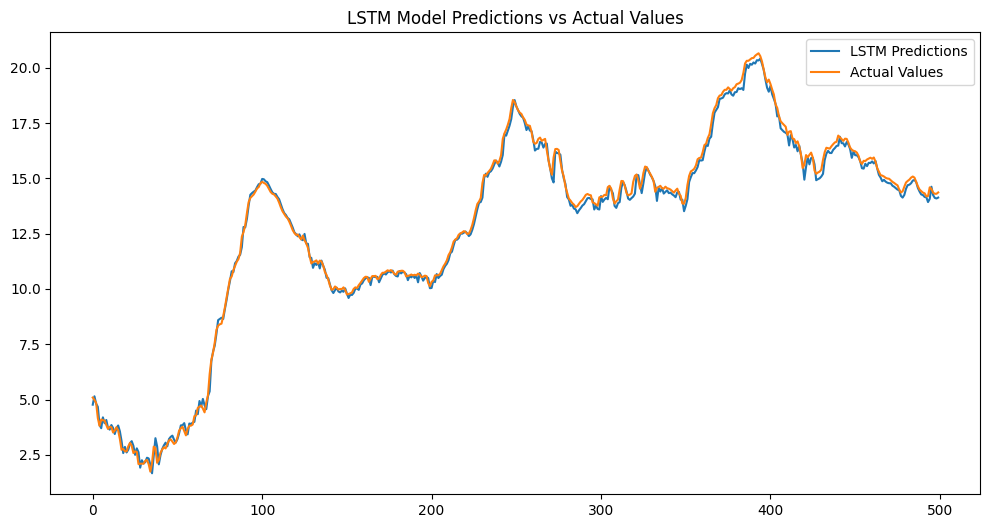

In [11]:
### Plot (a subset of) the predictions and actual values for the LSTM model on the test set

plt.figure(figsize=(12, 6))
plt.plot(preds_lstm[:500], label='LSTM Predictions')
plt.plot(actual_lstm[:500], label='Actual Values')
plt.legend()
plt.title('LSTM Model Predictions vs Actual Values')
plt.show()

## Part 2: The S4 State Space Model

A State Space Model (SSM) is a mathematical model for a dynamic system, whereby the system is modelled by state variables that change over time, and are affected by the inputs fed to the model. A basic representation of the state space model is found below (image and equations from [[5](https://en.wikipedia.org/wiki/State-space_representation)]): 

<img src="Images/State_Space_Model.png" style="width:800px;height:450px;">

The general mathematical model for this is the following:

$\dot{x}(t) = A(t)x(t) + B(t)u(t) \\$ 
$y(t) = C(t)x(t) + D(t)u(t) $

Each of these terms is defined by the following (assuming p inputs, q outputs, and n state variables):

<img src="Images/state_space_explanation.png" style="width:700px;height:400px;">

Now one problem with this, when it comes to using it for ML tasks, is that this is a continuous time system. However, analysis and training of continuous time systems can be quite slow (and sometimes impossible, if the data is not continuous). Hence, it becomes necessary to turn this into a discrete representation. This is possible (and if you want to learn more about how to do so, you can check out one of the following posts, the last of which some code was borrowed (s4.py) to make the S4 model: [[6](https://huggingface.co/blog/lbourdois/get-on-the-ssm-train)], [[7](https://tinkerd.net/blog/machine-learning/state-space-models/)], [[8](https://srush.github.io/annotated-s4/)], [[9](https://newsletter.maartengrootendorst.com/p/a-visual-guide-to-mamba-and-state)], [[10](https://julianstier.com/posts/2024/10/notes-on-transformer-and-s4-models/)]), but the important point is that by discretizing it the model can have different representations, such as a convolutional representation (which gives all the strengths and drawbacks of convolution), and a recurrent representation. 

Now one problem that is faced by SSM is that the A matrix needs to be calculated (multiplied by itself) multiple times. Matrix multiplications can be quite expensive, and sometimes numerically unstable, so choosing a good A matrix is very important! This is the driving force behind the S4 model (and others!). One thing the A matrix needs to do is somehow capture long-range dependencies in the data, and the HiPPO matrix can do so by (in a very rough sense) modelling the history of seen inputs. The S4 model helps this and provides some improved ways to calculate this matrix.

Just like the LSTM model, we will test our S4 model on the same data., so let's do so and see how it does!

In [12]:
### Define the S4 model. Details of the actual convolution/recurrent representations and the math of making the A matrix (and some other details) are in s4.py if you want to take a look.

class S4Model(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 128):
        super(S4Model, self).__init__()
        
        self.hidden_size = hidden_size
        self.encoder = nn.Linear(input_size, hidden_size)
        self.norm = nn.LayerNorm(hidden_size)
        self.s4 = S4Block(hidden_size)  # The State Space Model (S4 SSM)
        self.decoder = nn.Linear(hidden_size, 1)  # Final linear layer for regression output

    def forward(self, x):
        # Input x is shape (Batch, Time_window, input_size)
        h = self.encoder(x)  # (Batch, Time_window, input_size) -> (Batch, Time_window, hidden_size)

        # Pre-Norm
        h = h.transpose(-1, -2)  # (Batch, Time_window, hidden_size) -> (Batch, hidden_size, Time_window)
        h = self.norm(h.transpose(-1, -2)).transpose(-1, -2)
        
        # Pass through S4
        h, _ = self.s4(h)
        h = h.transpose(-1, -2) # (Batch, Time_window, hidden_size) -> (Batch, hidden_size, Time_window)

        # Pooling: average pooling over the sequence length
        h = h.mean(dim=1)  # (B, hidden_size, Time_window) -> (B, hidden_size)
        
        # Output at the last time step
        h = self.decoder(h)  # (B, hidden_size) -> (B, output_size)
        return h


In [13]:
### Create the S4 Model

s4model = S4Model(hidden_size=128)
s4model.to(device)
s4optimizer = optim.Adam(s4model.parameters())
s4loss_fn = nn.MSELoss()
print(f"Number of parameters in S4 model: {sum(param.numel() for param in s4model.parameters())}")

Number of parameters in S4 model: 66689


In [14]:
s4_start = dt.datetime.now()
train_model(s4model, trainloader, s4loss_fn, s4optimizer, 'S4', 50)
s4_end = dt.datetime.now()
print(f"S4 Training Time: {s4_end - s4_start}")

Epoch 1/50, Loss: 7.63979577404844
Epoch 2/50, Loss: 2.810967826972714
Epoch 3/50, Loss: 1.8982225327932012
Epoch 4/50, Loss: 1.400749423257068
Epoch 5/50, Loss: 0.8150806748583822
Epoch 6/50, Loss: 0.6291722587362067
Epoch 7/50, Loss: 0.512777052036796
Epoch 8/50, Loss: 0.467545863221172
Epoch 9/50, Loss: 0.45081327115333947
Epoch 10/50, Loss: 0.44039540055415655
Epoch 11/50, Loss: 0.4052291132922373
Epoch 12/50, Loss: 0.38115838691394366
Epoch 13/50, Loss: 0.3604541953345012
Epoch 14/50, Loss: 0.34189498653544936
Epoch 15/50, Loss: 0.321768606952865
Epoch 16/50, Loss: 0.2984482445280677
Epoch 17/50, Loss: 0.2846275579801878
Epoch 18/50, Loss: 0.2749103947651427
Epoch 19/50, Loss: 0.23884808603191554
Epoch 20/50, Loss: 0.21999075257909034
Epoch 21/50, Loss: 0.2035961147918534
Epoch 22/50, Loss: 0.1899529094798971
Epoch 23/50, Loss: 0.185338906469834
Epoch 24/50, Loss: 0.18325322891825072
Epoch 25/50, Loss: 0.14989672034939297
Epoch 26/50, Loss: 0.13487581126671003
Epoch 27/50, Loss: 0

In [15]:
### Get predictions and MSE for the S4 model on the test set
preds_s4, actual_s4 = evaluate_model(s4model, testloader, 'S4')
print(f"S4 SSM MSE on Test Set: {np.sum(np.sqrt(np.square(preds_s4 - actual_s4.squeeze())))/len(actual_s4)}")

S4 SSM MSE on Test Set: 0.1718486283592414


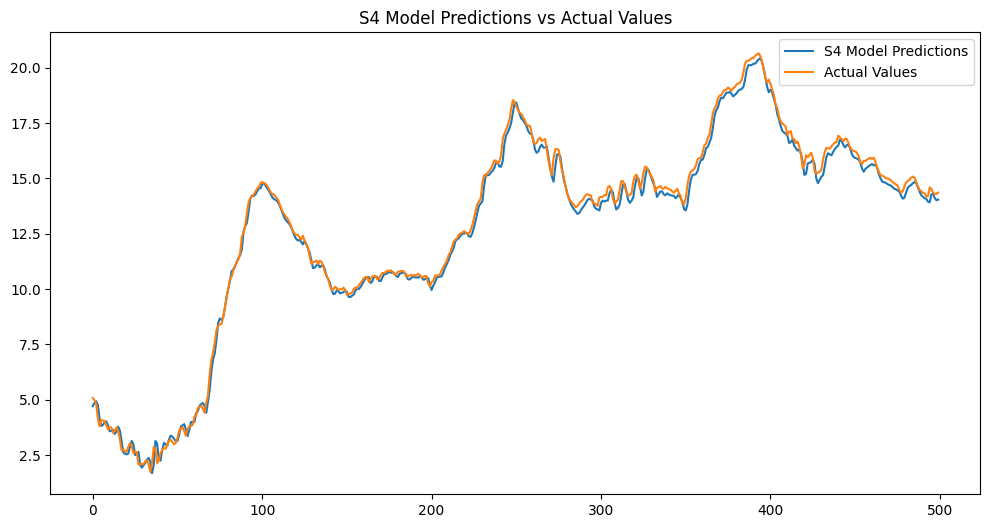

In [16]:
### Plot (a subset of) the predictions and actual values for the S4 model on the test set

plt.figure(figsize=(12, 6))
plt.plot(preds_s4[:500], label='S4 Model Predictions')
plt.plot(actual_s4[:500], label='Actual Values')
plt.legend()
plt.title('S4 Model Predictions vs Actual Values')
plt.show()

## Part 3: Questions

Now, we've got a basic understanding of these two models, and the code above to run them. So let's explore them a little further in these homework questions. For some questions, you may need to change and edit hyperparameters of the models and data (such as the time_window) to answer them. Exploration of the models are encouraged!

### Q1: What are some connections between a state space model (such as S4) and an LSTM network? How about with a recurrent network? What are some of the major differences?

### Q2: What effect does changing the time window have on both models? What length of time window is best (and would it be the same for both models)? Give some reasoning for why it would be best, and give a time window value you found works well. 

### Q3: What kind of effects does changing the size of the hidden states have on both models? Is there a best size, and does the performance change equally when each model is changed equally? Give some hidden_sizes you tried for each model and the test set MSE loss achieved. 

### Q4: Which model do you think works best and why? Are there certain tasks that one might perform better than the other? Can you compare their performance (both qualitatively and quantitatively) using the dataset in this notebook?